In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft
import cmath
import matplotlib as mpl
from matplotlib.lines import Line2D
import math
from math import radians, cos, sin, asin, sqrt

%matplotlib inline

# Load Data

In [2]:
input_path = 'E:/for_hendrik_20230316/'

# velocity = xr.open_mfdataset(input_path + 'velocity_raw_detrended.nc')

velocity = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')



# spectral_u = xr.open_dataset(input_path + 'spectral_u.nc')
# spectral_u['f_k'] = spectral_u.f_k_real + 1j*spectral_u.f_k_real

# spectral_v = xr.open_dataset(input_path + 'spectral_v.nc')
# spectral_v['f_k'] = spectral_v.f_k_real + 1j*spectral_v.f_k_real

# spectral_rotary = xr.open_dataset(input_path + 'spectral_rotary.nc')
# spectral_rotary['f_k'] = spectral_rotary.f_k_real + 1j*spectral_rotary.f_k_real


In [2]:
# input_path = '/home/hgrosselindemann/Documents/for_hendrik_20230316/'

# input_path = '/Users/2311043/Documents/GitHub/TORI/'
input_path = 'E:/for_hendrik_20230316/'

grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
# vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2013,1,1,0,0,0), datetime(2018,1,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [8]:
files = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for year in np.arange(2013,2018):
    for month in months:

        files.append(input_path + 'raw_data/' + f'{year}{month}.mat')

In [9]:
vel_u = scipy.io.loadmat(files[0])['u0_monthly']
vel_v = scipy.io.loadmat(files[0])['v0_monthly']


for file in files[1:]:
    u = scipy.io.loadmat(file)['u0_monthly']
    v = scipy.io.loadmat(file)['v0_monthly']
    
    vel_u = np.concatenate((vel_u,u),axis=-1)
    vel_v = np.concatenate((vel_v,v),axis=-1)    

In [10]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_u/100),
    'v':(['y','x','time'],vel_v/100)
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# means

In [392]:
u_dashed = velocity.u - velocity.u.mean(dim='time')
v_dashed = velocity.v - velocity.v.mean(dim='time')

eke_mean = ((u_dashed**2).mean(dim='time') + (v_dashed**2).mean(dim='time'))/2

In [11]:
eke = (velocity.u**2 + velocity.v**2)/2 - (velocity.u.mean(dim='time')**2 + velocity.v.mean(dim='time')**2)/2

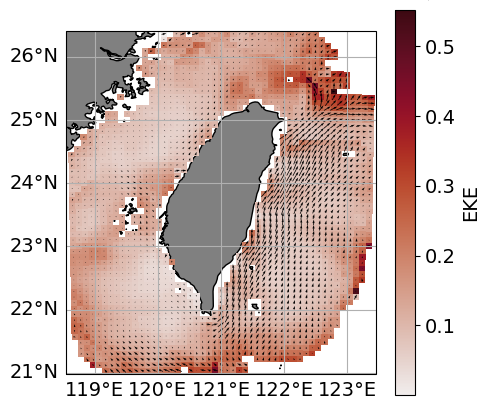

In [393]:
# fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

eke_mean.plot(ax=ax1,x='lon',y='lat',cmap=cmo.amp,cbar_kwargs={'label':'EKE'})
velocity.mean(dim='time').plot.quiver('lon','lat','u','v',ax=ax1)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

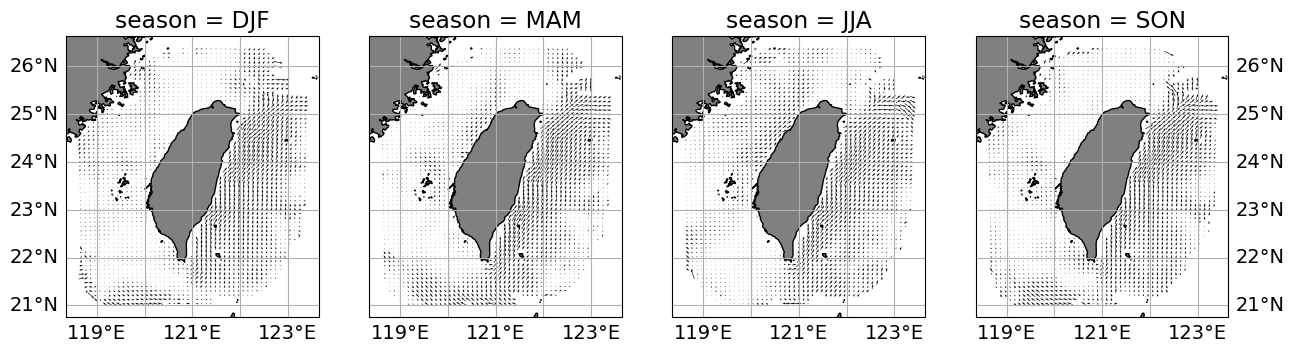

In [216]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

season_mean = velocity.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u','v',ax=ax1)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax2)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u','v',ax=ax3)
season_mean.sel(season='SON').plot.quiver('lon','lat','u','v',ax=ax4)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

# Data Coverage

In [3]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask,axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage

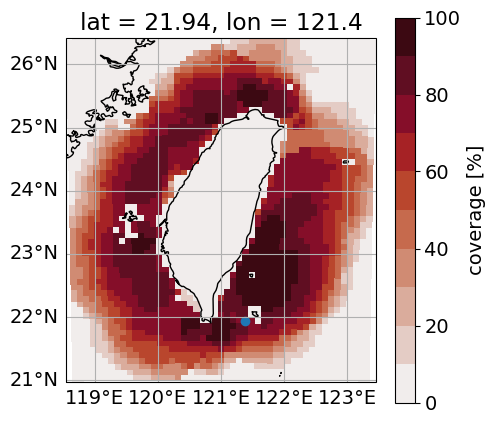

In [4]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

# ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# for x,y in zip(x_idx,y_idx):
#     xr.plot.scatter(ds=velocity.isel(x=x,y=y),x='lon',y='lat',color='b')
xr.plot.scatter(ds=velocity.isel(x=28,y=10),x='lon',y='lat')
# plt.scatter(longitudes,latitudes,transform=ccrs.PlateCarree(),marker='x')

# De-mean and De-trend

In [225]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim),da.mean(dim=dim)

def detrend_xarray(da):
    '''
    apply detrend along time axis of 2D Xarray
    see polynomial_detrend for details about detrending
    '''
    dt = xr.apply_ufunc(
                polynomial_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time','dim0']],
                vectorize=True,
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x','dim0')
    
    return dt.isel(dim0=0),dt.isel(dim0=1)

def polynomial_detrend(da,order=1):
    '''
    detrend of non uniform data on a uniform grid with nan values
    
    change order to increase order of fittet polynomial, default is 1, so linear
    
    returns detrended data and trend values
    '''
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return np.stack((ds,ds),axis=-1)
    else:
        ds_masked = ds[mask]
        time = np.arange(0,len(ds))
        time_masked = time[mask]
        coeff = np.polyfit(time_masked, ds_masked, order)
        trend_nonan = np.polyval(coeff, time_masked)
        detrended = ds_masked - trend_nonan
        ds[mask] = detrended
        trend = np.copy(ds)
        trend[mask] = trend_nonan
        
        return np.stack((ds.data,trend),axis=-1)

In [54]:
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v,dim='time')

In [63]:
velocity['u_detrended'],velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'],velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

In [65]:
velocity.to_netcdf(input_path + 'velocity_raw_detrended.nc')

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

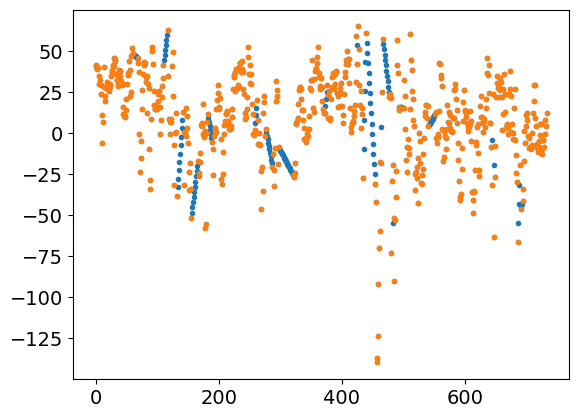

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# Spectral analysis

## uniform FFT

In [6]:
# try xrft.power_spectrum

In [35]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform FFT

In [91]:
def nufft(data,xarray_apply=True):
    '''
    does a non-uniform fast fourier transform on data with a uniform grid but nan values in it
    
    returns freq: frequency in cycles per timestep (cph for hourly data)
            f_k: amplitude for each wavenumber k as a complex number
            ps: power spectrum
            psd: power spectral density
            
    xarray_apply is used for the spectral_analysis function for apply_ufunc along time dimension for each point of spatial array
        if you just want to do it for one array time series, set it to False
    
    function is taken from https://github.com/jakevdp/nfft
    '''
    mask = ~np.isnan(data)
    
    N_freq = len(data)
    k = -N_freq//2 + np.arange(N_freq)
    
    data_masked = (data)[mask]
    t = np.linspace(0, 1,N_freq)[mask]
    
    f_k = nfft.nfft_adjoint(t,data_masked,N_freq)
    ps = np.abs(f_k)**2/N_freq**2
    psd = ps * N_freq
    freq = k/N_freq
    if xarray_apply == True:
        t_return = np.linspace(0, 1,N_freq)
        t_return[~mask] = np.nan
        return np.stack((freq,f_k,ps,psd,t_return),axis=-1)
    elif xarray_apply==False:
        return freq,f_k,ps,psd,t

In [4]:
def spectral_analysis(da):
    '''
    apply the nufft on each spatial point of a 2D dataset along the timeseries
    returns xarray DataSet with frequency spectrum, powerspectrum, power spectral density for each point
    t is masked time array without nans, necessary for reconstruction of time series from frequency spectrum
    '''
    dt = xr.apply_ufunc(
                nufft,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['freq','dim0']],
                vectorize=True,
                output_dtypes=['complex'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'freq':744,'dim0':5}}
            )
    dt = xr.Dataset(coords={
        'lat':(['y','x'],dt['lat'].data),
        'lon':(['y','x'],dt['lon'].data),
        'freq':np.real(dt[0,0,:,0].data)
    },data_vars={
        'f_k':(['y','x','freq'],dt.isel(dim0=1).data),
        'ps':(['y','x','freq'],np.real(dt.isel(dim0=2).data)),
        'psd':(['y','x','freq'],np.real(dt.isel(dim0=3).data)),
        't':(['y','x','freq'],np.real(dt.isel(dim0=4).data))
        

    })
    dt = dt.transpose('freq','y','x')
    # dt = dt.where(dt!=0)
    return dt

# hann = xr.DataArray(coords={'time':velocity.time.values},data=np.hanning(744))
# spectral_u_hann = spectral_analysis(velocity.u_demeaned*hann)

In [5]:
# spectral_u = spectral_analysis(velocity.u_detrended)
spectral_v = spectral_analysis(velocity.v_detrended)

spectral_v = spectral_v.where(spectral_v!=0)

spectral_v_nocomplex = spectral_v.copy()

spectral_v_nocomplex['f_k_real'] = np.real(spectral_v_nocomplex.f_k)
spectral_v_nocomplex['f_k_imag'] = np.imag(spectral_v_nocomplex.f_k)

spectral_v_nocomplex = spectral_v_nocomplex.drop(['f_k'])

spectral_v_nocomplex.to_netcdf(input_path + 'spectral_v.nc')

In [92]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nufft(velocity.u_filtered[:,12,28],xarray_apply=False)

In [70]:
freq_hann,f_k_hann,ps_hann,psd_hann,t_hann = nufft(velocity.v_detrended[:,12,28],xarray_apply=False)

In [20]:
freq_pos = freq[372:]

f_k_pos = np.ones((372))*f_k[372:]
f_k_pos[1:] = f_k_pos[1:]*2

ps_pos = np.ones((372))*ps[372:]
ps_pos[1:] = ps_pos[1:]*2

psd_pos = np.ones((372))*psd[372:]
psd_pos[1:] = psd_pos[1:]*2

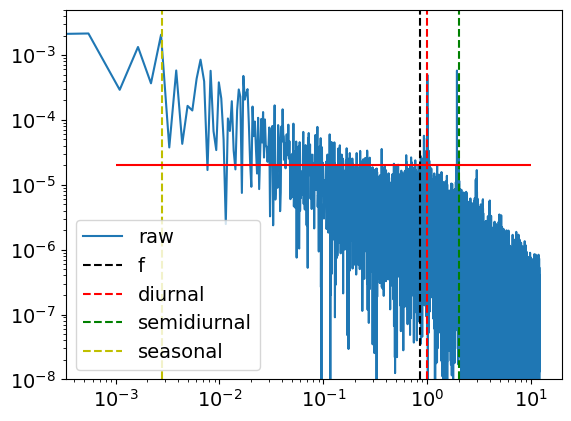

In [102]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.loglog(freq*24,ps,label='raw')

# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=28,y=12).ps,label='filtered')
# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=12,y=28).ps,label='filtered')


# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=10,y=10).ps,label='filtered')
# plt.loglog(spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).freq*24,spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).ps)
# plt.loglog(spectral_u_hann.isel(x=10,y=10).freq*24,spectral_u_hann.isel(x=10,y=10).ps,label='hann')
# plt.loglog(spectral_u.isel(x=10,y=10).freq*24,spectral_u.isel(x=10,y=10).ps,label='detrend')

ymin,ymax = 1e-8,5e-3
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.8e-3],ymin,ymax,color=['y'],linestyle='--',label='seasonal')

# plt.vlines(spectral_u.freq[test[0]+idx].data*24,ymin,ymax,color='k')
plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

plt.hlines(2e-5,1e-3,10,color='r')
# plt.savefig('/Users/2311043/Documents/GitHub/TORI/spectrum_filtervsraw.png')

## Rotary spectrum

In [5]:
spectral_rotary = spectral_analysis(velocity.u_detrended+1j*velocity.v_detrended)

spectral_rotary = spectral_rotary.where(spectral_rotary!=0)

spectral_rotary_nocomplex = spectral_rotary.copy()

spectral_rotary_nocomplex['f_k_real'] = np.real(spectral_rotary_nocomplex.f_k)
spectral_rotary_nocomplex['f_k_imag'] = np.imag(spectral_rotary_nocomplex.f_k)

spectral_rotary_nocomplex = spectral_rotary_nocomplex.drop(['f_k'])

spectral_rotary_nocomplex.to_netcdf(input_path + 'spectral_rotary.nc')

In [12]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,28,12]+1j*velocity.v_detrended[:,28,12],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,t = nufft(velocity.u_filtered[:,10,10]+1j*velocity.v_filtered[:,10,10],xarray_apply=False)

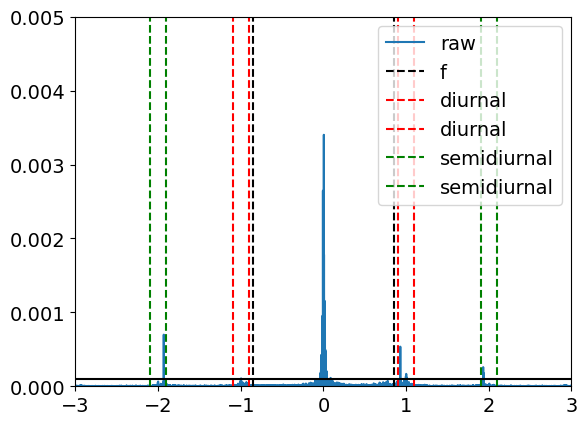

In [415]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.plot(spectral_rotary.freq*24,spectral_rotary.isel(x=10,y=10).ps,label='raw')
# plt.plot(freq*24,ps_filtered,label='filtered')

plt.xlim([-3,3])
ymin,ymax = 0,0.005
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
# plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([0.9,1.1,-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
# plt.vlines([-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')

# plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.1,-2.1,1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
# plt.vlines([1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.hlines(1e-4,-3,3,color='k')
plt.legend()
plt.ylim([ymin,ymax]);

# plt.savefig('/Users/2311043/Documents/GitHub/TORI/spectrum_rotary.png')

## find peaks

In [12]:
def peak_finder(freq_data,ps_data,freq_min,freq_max,peak_height):
    '''
    find amplitude and frequency of maximum peak in frequency range of spectrum
    freq_data, ps_data: frequency values and powerspectrum
    freq_min, freq_max: bounds of frequency range
    peak_height: threshold for peak to detect
    
    if you want to detect on frequency amplitudes or power spectral density, adjust peak_height accordingly, should work
    
    returns maximum peak and according frequency
    '''
    
    freq_mask = np.array([freq_data > freq_min]) & np.array([freq_data < freq_max])
    freq_mask = np.squeeze(freq_mask)
    peaks,peak_heights = scipy.signal.find_peaks(ps_data[freq_mask],height=peak_height)
    freq_peaks = freq_data[freq_mask][peaks]
    if len(peak_heights['peak_heights']) != 0:
        peak_max = max(peak_heights['peak_heights'])
        freq_max = freq_peaks[peak_heights['peak_heights'] == peak_max]
    else:
        peak_max,freq_max = np.nan,np.nan
    
    return np.array([freq_max,peak_max])

In [13]:
def find_peaks_xr(data,freq_min,freq_max,peak_height):
    '''
    apply peak_finder for each point of spatial xarray
    '''
    ds = xr.apply_ufunc(
                peak_finder,
                data.freq,
                data.ps,
                freq_min,
                freq_max,
                peak_height,
                input_core_dims=[['freq'],['freq'],[],[],[]],
                output_core_dims=[['peak']],
                vectorize=True,
                output_dtypes=['float'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'peak':2}}
            )
    return ds

In [14]:
diurnal_u = find_peaks_xr(spectral_u,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_u = find_peaks_xr(spectral_u,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

diurnal_v = find_peaks_xr(spectral_v,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_v = find_peaks_xr(spectral_v,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

C:\Users\2311043\AppData\Local\Temp\ipykernel_3628\1391194171.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


### u

(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

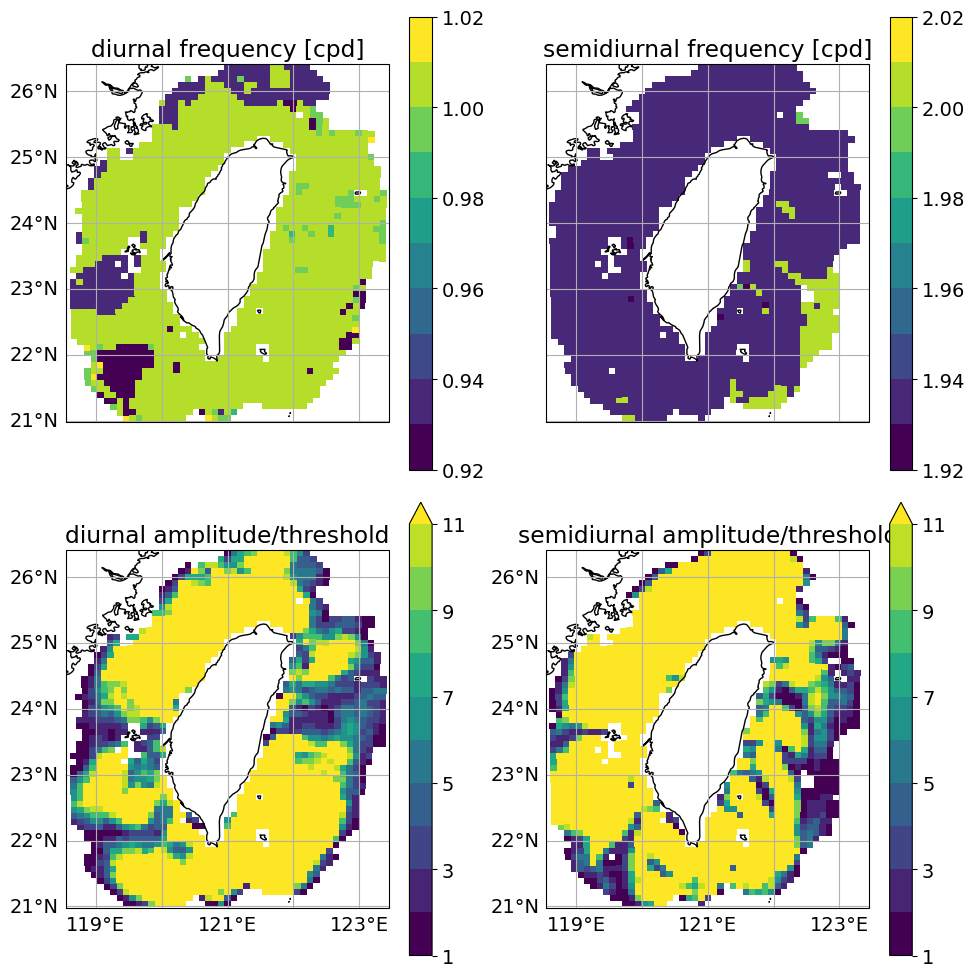

In [15]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

### v

(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

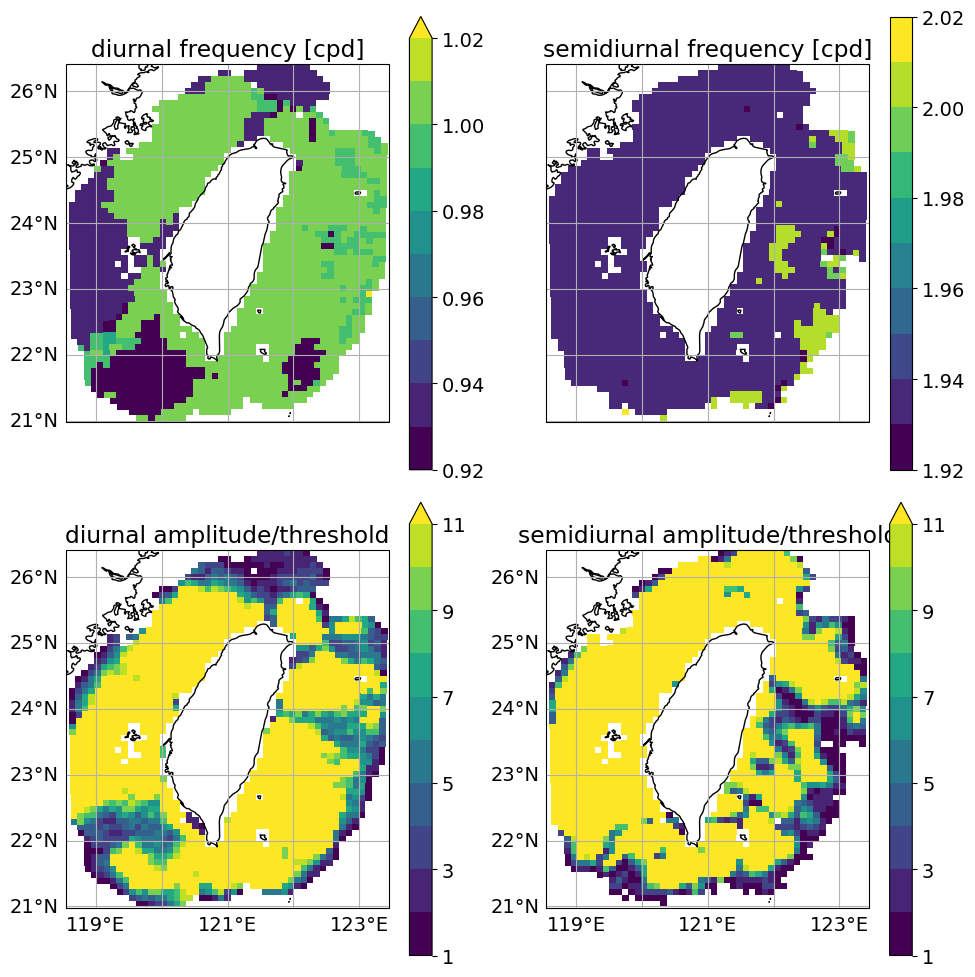

In [16]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

### rot

In [22]:
def peak_finder_rot(freq_data,ps_data,freq_min,freq_max,peak_height):
    '''
    find amplitude and frequency of maximum peak in frequency range of rotary spectrum
    freq_data, ps_data: frequency values and powerspectrum
    freq_min, freq_max: bounds of frequency range
    peak_height: threshold for peak to detect
    
    if you want to detect on frequency amplitudes or power spectral density, adjust peak_height accordingly, should work
    
    returns maximum peak and according frequency within combined positive and negative range
    '''
    freq_mask = (np.array([freq_data > freq_min]) & np.array([freq_data < freq_max])) + (np.array([freq_data < -freq_min]) & np.array([freq_data > -freq_max]))
    freq_mask = np.squeeze(freq_mask)
    peaks,peak_heights = scipy.signal.find_peaks(ps_data[freq_mask],height=peak_height)
    freq_peaks = freq_data[freq_mask][peaks]
    if len(peak_heights['peak_heights']) != 0:
        peak_max = max(peak_heights['peak_heights'])
        freq_max = abs(freq_peaks[peak_heights['peak_heights'] == peak_max])
    else:
        peak_max,freq_max = np.nan,np.nan
    
    return np.array([freq_max,peak_max])

In [23]:
def find_peaks_rot_xr(data,freq_min,freq_max,peak_height):
    '''
    apply peak_finder_rot for each point of spatial xarray
    '''
    ds = xr.apply_ufunc(
                peak_finder_rot,
                data.freq,
                data.ps,
                freq_min,
                freq_max,
                peak_height,
                input_core_dims=[['freq'],['freq'],[],[],[]],
                output_core_dims=[['peak']],
                vectorize=True,
                output_dtypes=['float'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'peak':2}}
            )
    return ds

In [24]:
diurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=0.9/24,freq_max=1.1/24,peak_height=1e-4)
semidiurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=1.9/24,freq_max=2.1/24,peak_height=1e-4)

C:\Users\2311043\AppData\Local\Temp\ipykernel_3628\1449752959.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

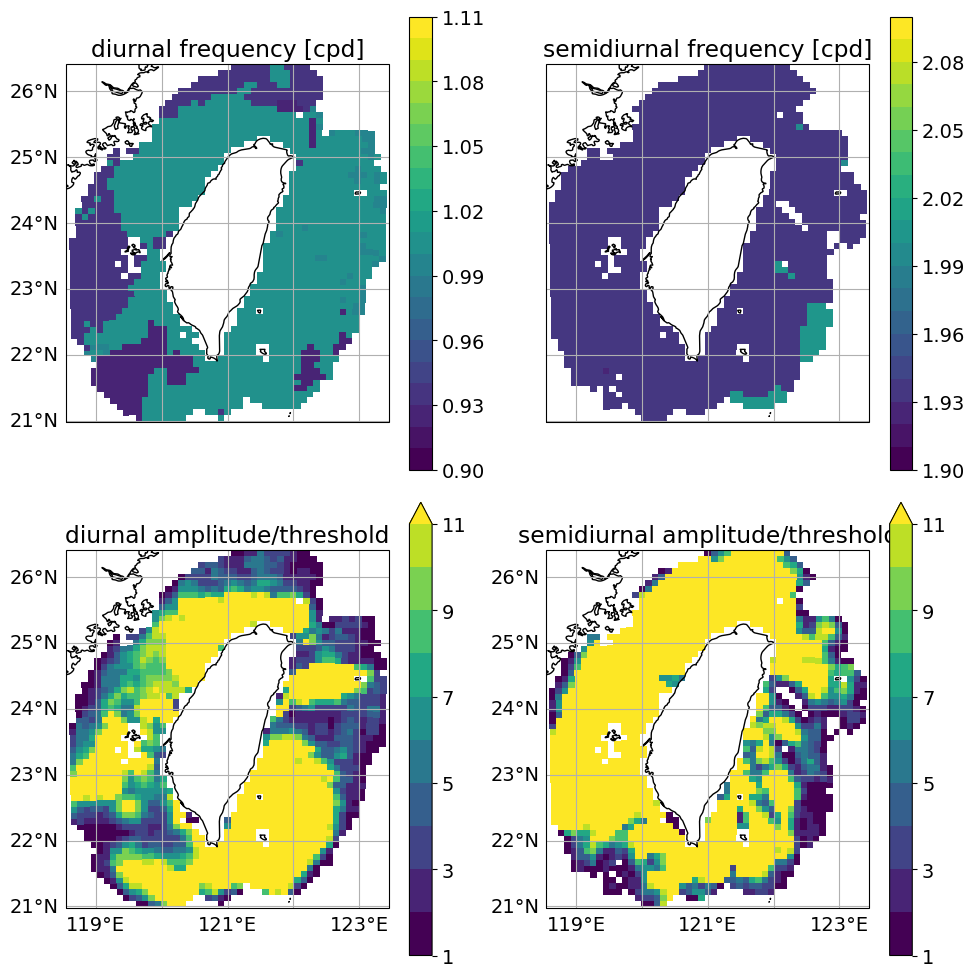

In [25]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.9,1.11,0.01))
(diurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.9,2.11,0.01))
(semidiurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

# tidal ellipse

In [232]:
def find_nearest(array, value):
    '''
    finds value and idx of value in array that is closest to the looked for value
    '''
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

In [233]:
def ellipse_details(fm,fp):
    '''
    calculates major and minor axis as well as azimuth angle of spectral ellipse from positive and negative frequency amplitudes
    see Walden2012 for mathematical insights
    '''
    Rp = np.abs(fp) + np.abs(fm)
    Rm = np.abs(np.abs(fp) - np.abs(fm))

    major = np.abs(Rp + Rm)
    minor = np.abs(Rp - Rm)

    azimuth = cmath.phase(fp*fm)/2
    return major,minor,azimuth

In [430]:
value,f_index = find_nearest(spectral_rotary.freq*24,1)

In [436]:
x=10;y=10
fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k

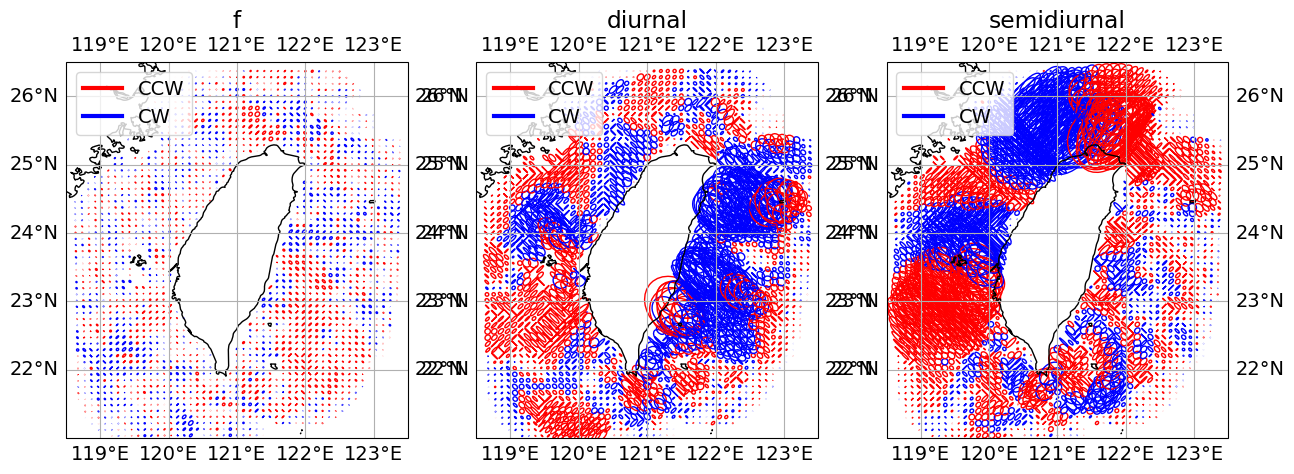

In [447]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24
colors = ['r', 'b']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = [ 'CCW', 'CW']

fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,f,title in zip(axs.ravel(),[f_coriolis,1,2],['f','diurnal','semidiurnal']):
    value,f_index = find_nearest(spectral_rotary.freq*24,f)
    for x in range(49):
        for y in range(60):
            fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k
            if ~np.isnan(np.abs(fm)):
                major,minor,azimuth = ellipse_details(fm,fp)
                lonlat = [fm.lon.data ,  fm.lat.data]
                rot = int(np.abs(fp).data > np.abs(fm).data)
                ell = mpl.patches.Ellipse(xy=lonlat, width=major/1e4, height=minor/1e4, angle = azimuth*180/np.pi,fc='none',ec=['b','r'][rot],transform=ccrs.PlateCarree())

                ax.add_patch(ell)
            else:
                continue
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_title(title)
    ax.legend(lines,labels,loc='upper left')
    ax.set_extent([118.5,123.5,21,26.5])
# plt.savefig('/Users/2311043/Documents/GitHub/TORI/tidal_ellipses.png')

# time filtering

In [4]:
def hann_window(n,T):
    '''
    calculates the frequency spectrum of a hanning window for n samples leading to n frequencies and T window size
    n has to be integer and n % 2 has to be 0
    '''
    assert n%2==0
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)

    w_transform = np.abs(np.fft.fft(w, n=n))
    mid_index = int(n/2)
    amp_hann = np.concatenate((w_transform[mid_index:],w_transform[:mid_index]))
    freq_hann = np.concatenate((freq_hann[mid_index:],freq_hann[:mid_index]))
    return freq_hann,amp_hann

def butterworth_window(n,fc,order):
    '''
    calculates the frequency spectrum of a butterworth window for n samples leading to n frequencies and fc cut off frequency with order of butterworth filter 
    n has to be integer and n % 2 has to be 0
    fs is sample frequency in Hz, we have hourly data, so 1/3600
    '''
    
    assert n%2==0
    fs = 1/3600
    nyq = 0.5 * fs
    fc = fc * (1/3600)
    freqs = (-n//2 + np.arange(n))/n/3600

    b,a = scipy.signal.butter(N=order,Wn=fc,btype='lowpass',fs = fs)
    freq_but, amp_but = scipy.signal.freqz(b,a,fs=fs,worN=freqs)
    return freq_but*3600, amp_but

In [234]:
def drop_na(data):
    '''
    drops all nan values from 1D array
    '''
    mask = ~np.isnan(data)
    return data[mask]

In [6]:
def inverse_nufft(t,f_k):
    '''
    inverse fourier transform to get back time series from fourier components
    non-uniform discrete fourier transform
    
    returns array of reconstructed velocities on the complete time grid, so with nan values
    '''
    reconstructed = nfft.nfft(drop_na(t), f_k)/len(f_k)
    reconstructed_ontime = np.copy(t)
    reconstructed_ontime[~np.isnan(t)] = reconstructed
    return reconstructed_ontime

def inverse_nufft_window(t,f_k,window_amplitudes):
    '''
    inverse fourier transform to get back time series from fourier components
    non-uniform discrete fourier transform but with amplitude taken out of high frequencies using a hanning window, which has to be predefined
    
    returns array of reconstructed velocities on the complete time grid, so with nan values
    '''
    reconstructed = nfft.nfft(drop_na(t), f_k*window_amplitudes)/len(f_k)
    reconstructed_ontime = np.copy(t)
    reconstructed_ontime[~np.isnan(t)] = reconstructed
    return reconstructed_ontime

In [7]:
def filter_window(spectral_data,window_type,**parameters):
    '''
    apply inverse nufft on 2D xarray dataset with a frequency filter applied
    returns xarray DataArray of reconstructed filtered velocities on each point in space
    '''
    if window_type == 'hanning':
        freq,amp = hann_window(len(spectral_data.freq),parameters['T'])
    elif window_type == 'butterworth':
        freq,amp = butterworth_window(len(spectral_data.freq),parameters['fc'],parameters['order'])
        
    dt = xr.apply_ufunc(
                inverse_nufft_window,
                spectral_data.t,
                spectral_data.f_k,
                amp,
                input_core_dims=[['freq'],['freq'],['time']],
                output_core_dims=[['time']],
                vectorize=True,
                output_dtypes=[np.dtype(float)],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x').assign_coords({'time':velocity.time.values})
    return dt

u_reconstructed_hann = filter_window(spectral_u,'hanning',T=49)
u_reconstructed_but = filter_window(spectral_u,'butterworth',fc=1/40,order=10)

# v_reconstructed_hann = filter_window(spectral_v,'hanning',T=49)
# v_reconstructed_but = filter_window(spectral_v,'butterworth',fc=1/40,order=10)

C:\Users\2311043\AppData\Local\Temp\ipykernel_300\2035454555.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed
C:\Users\2311043\AppData\Local\Temp\ipykernel_300\2035454555.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed


you need to add mean and trend again!

In [8]:
u_filtered_but = u_reconstructed_but + velocity.u_trend + velocity.u_mean
u_filtered_hann = u_reconstructed_hann + velocity.u_trend + velocity.u_mean

# v_filtered_but = v_reconstructed_but + velocity.v_trend + velocity.v_mean
# v_filtered_hann = v_reconstructed_hann + velocity.v_trend + velocity.v_mean

In [9]:
u_filtered_but.to_netcdf(input_path + 'u_filtered_but.nc')
u_filtered_hann.to_netcdf(input_path + 'u_filtered_hann.nc')

# v_filtered_but.to_netcdf(input_path + 'v_filtered_but.nc')
# v_filtered_hann.to_netcdf(input_path + 'v_filtered_hann.nc')

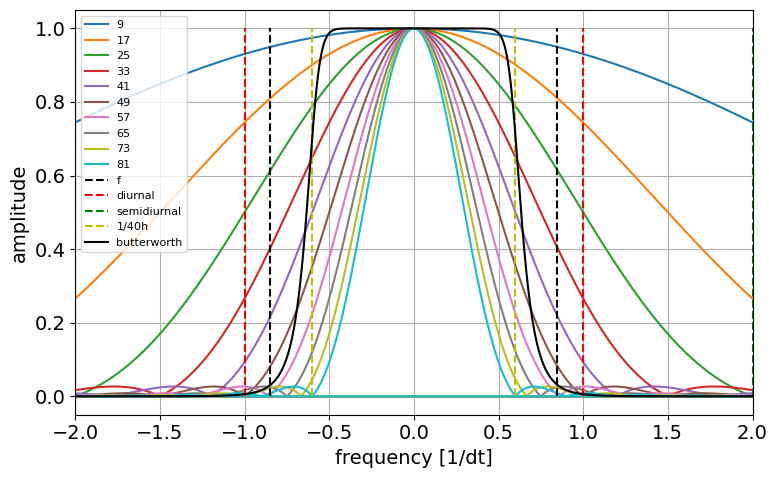

In [150]:
n = 43824

f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]
# axs[0].plot(freq_pos*24,ps_pos/ps_pos.max(),label='power spectrum')

for k in np.arange(4, 44, 4):
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)
    w_transform = np.fft.fft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    plt.plot(freq_hann*24, np.abs(w_transform),label=str(T))
    
#     plt.sca(axs[1])
#     plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()

ymin,ymax = 0,1
plt.vlines([-f_coriolis,f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([-1,1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([-2,2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([-24/40,24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h')

fs = 1/3600
nyq = 0.5 * fs
fc = 1/(40*3600)
freqs = freq/3600

b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)
plt.plot(w*3600*24, abs(h),color='k',label='butterworth')


plt.legend(loc='upper left',fontsize=8)
plt.xlim([-2,2])
# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
# plt.savefig('../img/9_filtering_4.svg', bbox_inches='tight', pad_inches=.1);

C:\Users\2311043\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


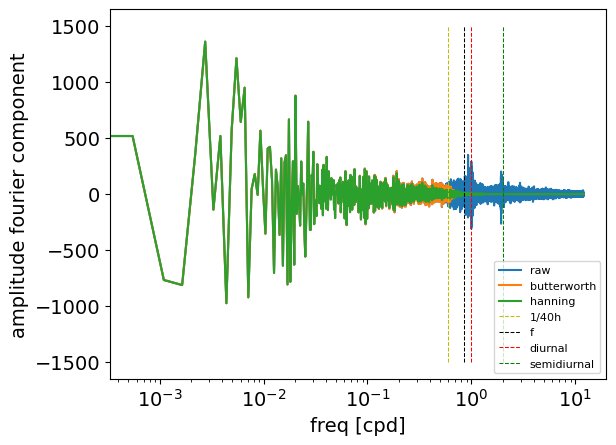

In [221]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,10,10],xarray_apply=False)
# fs = 1/3600
# nyq = 0.5 * fs
# fc = 1/(40*3600)
# freqs = freq/3600

# b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
# w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)

freq_but,amp_but = butterworth_window(43824,1/40,10)
freq_hann,amp_hann = hann_window(43824,49)


plt.semilogx(freq*24,f_k,label='raw')
plt.semilogx(freq*24,f_k*abs(amp_but),label='butterworth')
plt.semilogx(freq*24,f_k*abs(amp_hann),label='hanning')


ymin,ymax = -1500,1500
plt.vlines([-24/40,24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h',linewidth=0.75)
plt.vlines([-f_coriolis,f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f',linewidth=0.75)
plt.vlines([-1,1],ymin,ymax,color=['r'],linestyle='--',label='diurnal',linewidth=0.75)
plt.vlines([-2,2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal',linewidth=0.75)

plt.legend(loc='lower right',fontsize=8)

plt.xlabel('freq [cpd]')
plt.ylabel('amplitude fourier component')

# plt.savefig('/Users/2311043/Documents/GitHub/TORI/fk_filters.png')

# Section Extraction

In [7]:
def find_nearest(array, value):
    '''
    finds value and idx of value in array that is closest to the looked for value
    '''
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def unique(sequence):
    '''
    finds unique values of array while keeping the order of values in array
    (set() orders values in increasing way)
    '''
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def section_indices(data,point1,point2):
    '''
    get x,y indices of section between latlon point1 and point2
    
    uses haversine distance to look for closest points on latlon grid to given latlon point
    
    first defines straight latlon line between point1 and point2
    
    then looks for closest points on grids to this line
    
    straight line has higher resolution than grid, so we discard all the x,y points that appear twice
    '''
    lat = np.asarray(data.lat.data)
    lon = np.asarray(data.lon.data)
    
    lat1,lon1 = point1
    lat2,lon2 = point2
    

    f = np.frompyfunc(haversine,4,1)
    value, indices1 = find_nearest(f(lon,lat,lon1,lat1).astype(float),0)
    value, indices2 = find_nearest(f(lon,lat,lon2,lat2).astype(float),0)

    x_dist = np.abs(indices1[1] - indices2[1]) 
    y_dist = np.abs(indices1[0] - indices2[0]) 

    dist_max = max(x_dist,y_dist)

    if (lat1-lat2) == 0:
        longitudes = np.linspace(lon1, lon2, dist_max*2)
        latitudes = np.ones(dist_max*2)*lat1
    elif (lon1-lon2) == 0:
        latitudes = np.linspace(lat1, lat2, dist_max*2)
        longitudes = np.ones(dist_max*2)*lon1
    else:
        latitudes = np.linspace(lat1, lat2, dist_max*2)
        longitudes = (lon2 - lon1)/(lat2 - lat1)*(latitudes - lat1) + lon1

    # x_idx = []
    # y_idx = []
    indices = []
    
    for i in range(dist_max*2):
        dummy = find_nearest(f(lon,lat,longitudes[i],latitudes[i]).astype(float),0)[1]
        # x_idx.append(dummy[1])
        # y_idx.append(dummy[0])
        indices.append((dummy[1],dummy[0]))
    indices = unique(indices)
    x_idx = [x[0] for x in indices]
    y_idx = [x[1] for x in indices]
    
    return x_idx,y_idx,latitudes,longitudes

In [8]:
north_section_ = section_indices(velocity,(26,120),(25,121))
mid_section_ = section_indices(velocity,(24.65,118.75),(24,120.25))
south_section_ = section_indices(velocity,(23.1,118.5),(23.1,120))

In [9]:
def section_distance(data):
    '''
    calculates haversine distance along section from most east point to west in increasing way
    here it is the distance from the Taiwan coast, if you set the starting point correctly
    '''
    distance = [0]
    for i in -np.arange(2,len(data.lon.data)+1):
        distance.append(haversine(data.lon.data[i],data.lat.data[i],data.lon.data[i+1],data.lat.data[i+1]))
    section_distance = np.cumsum(distance)
    return np.flip(section_distance)

In [10]:
def extract_section(data,point1,point2):
    '''
    extracts section on latlon grid between point1 and point2
    adds distance along section as coordinate
    '''
    x_idx,y_idx,latitudes,longitudes = section_indices(data,point1,point2)

    section = data.isel(x=xr.DataArray(x_idx, dims="s"), y=xr.DataArray(y_idx, dims="s"))
    section = section.assign_coords({'distance':('s',section_distance(section))})
    return section

north_section = extract_section(velocity,(26,120),(25,121))
mid_section = extract_section(velocity,(24.65,118.75),(24,120.25))
south_section = extract_section(velocity,(23.1,118.5),(23.1,120))

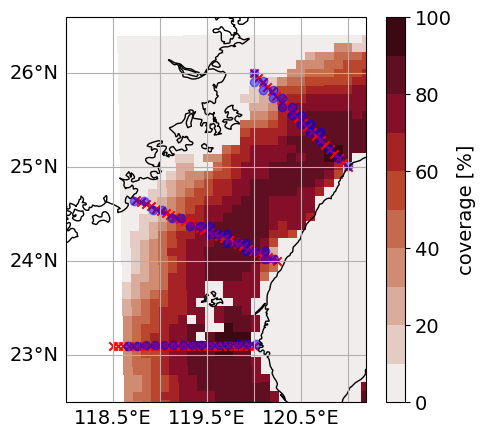

In [11]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

ax1.set_extent([118,121.2,22.5,26.6])
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

plt.scatter(north_section_[3],north_section_[2],color='r',marker='x')
plt.scatter(mid_section_[3],mid_section_[2],color='r',marker='x')
plt.scatter(south_section_[3],south_section_[2],color='r',marker='x')



xr.plot.scatter(ds=north_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=mid_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=south_section,x='lon',y='lat',color='b',alpha=0.5)

# rotate velocities

In [12]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [13]:
def rotate_velocities(u,v,angle):
    '''
    rotates velocity vector in mathematical positive direction
    '''
    
    u_ = u * np.cos(angle) - v * np.sin(angle)
    v_ = u * np.sin(angle) + v * np.cos(angle)
    
    return u_,v_

In [14]:
def rotate_section(section):
    '''
    rotate velocities on section to cross and along section velocities
    
    !!! This heavily depends on how you defined the section !!!
    
    The initial rotation angle is calculated as the compass bearing between two latlon points. I then substract 90deg and change the sign.
    This leads to a clockwise rotation with the angle being between the cartesian axis and the section. However, the
    initinal angle depends on which one is entered first, leading to a difference of 180deg.
    So check the compass bearing between your point first and think about if this leads to the velocites ending up in the way you want.
    I wanted u to be mostly eastward and v to be mostly northward
    
    '''
    point1 = (section.isel(s=0).lat.data,section.isel(s=0).lon.data)
    point2 = (section.isel(s=-1).lat.data,section.isel(s=-1).lon.data)
    
    angle = np.deg2rad(calculate_initial_compass_bearing(point1,point2))
    angle = angle = -(angle- np.pi/2)
    
    section['cross_vel'],section['along_vel'] = rotate_velocities(section.u_filtered,section.v_filtered,angle)
    return section

In [15]:
north_section = rotate_section(north_section)
mid_section = rotate_section(mid_section)
south_section = rotate_section(south_section)

In [17]:
north_mean = north_section.mean(dim='time')

north_u_std = north_section.along_vel.std(dim='time')
north_v_std = north_section.cross_vel.std(dim='time')

mid_mean = mid_section.mean(dim='time')

mid_u_std = mid_section.along_vel.std(dim='time')
mid_v_std = mid_section.cross_vel.std(dim='time')

south_mean = south_section.mean(dim='time')

south_u_std = south_section.along_vel.std(dim='time')
south_v_std = south_section.cross_vel.std(dim='time')

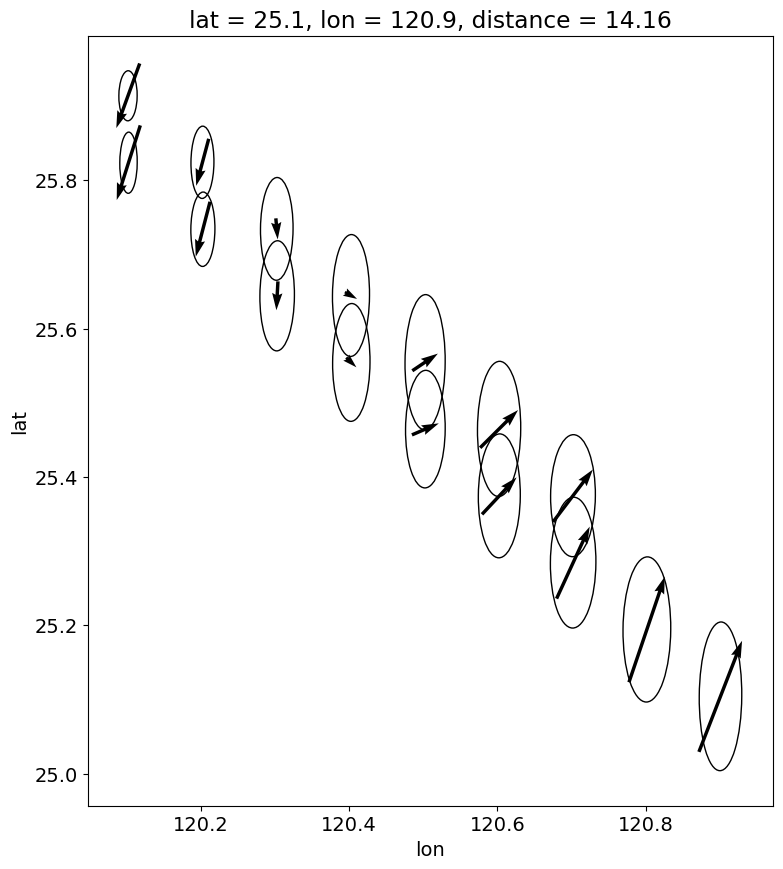

In [74]:
fig,ax= plt.subplots(1,1,figsize=(10,10))
for s in np.arange(2,len(north_mean.s)-1):
    north_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[north_section.isel(s=s).lon,north_section.isel(s=s).lat],
                              width=north_u_std.isel(s=s), height=north_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (north_section.lon[0],north_section.lat[0]),(north_section.lon[-1],north_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    ax.set_aspect('equal')
    ax.autoscale()

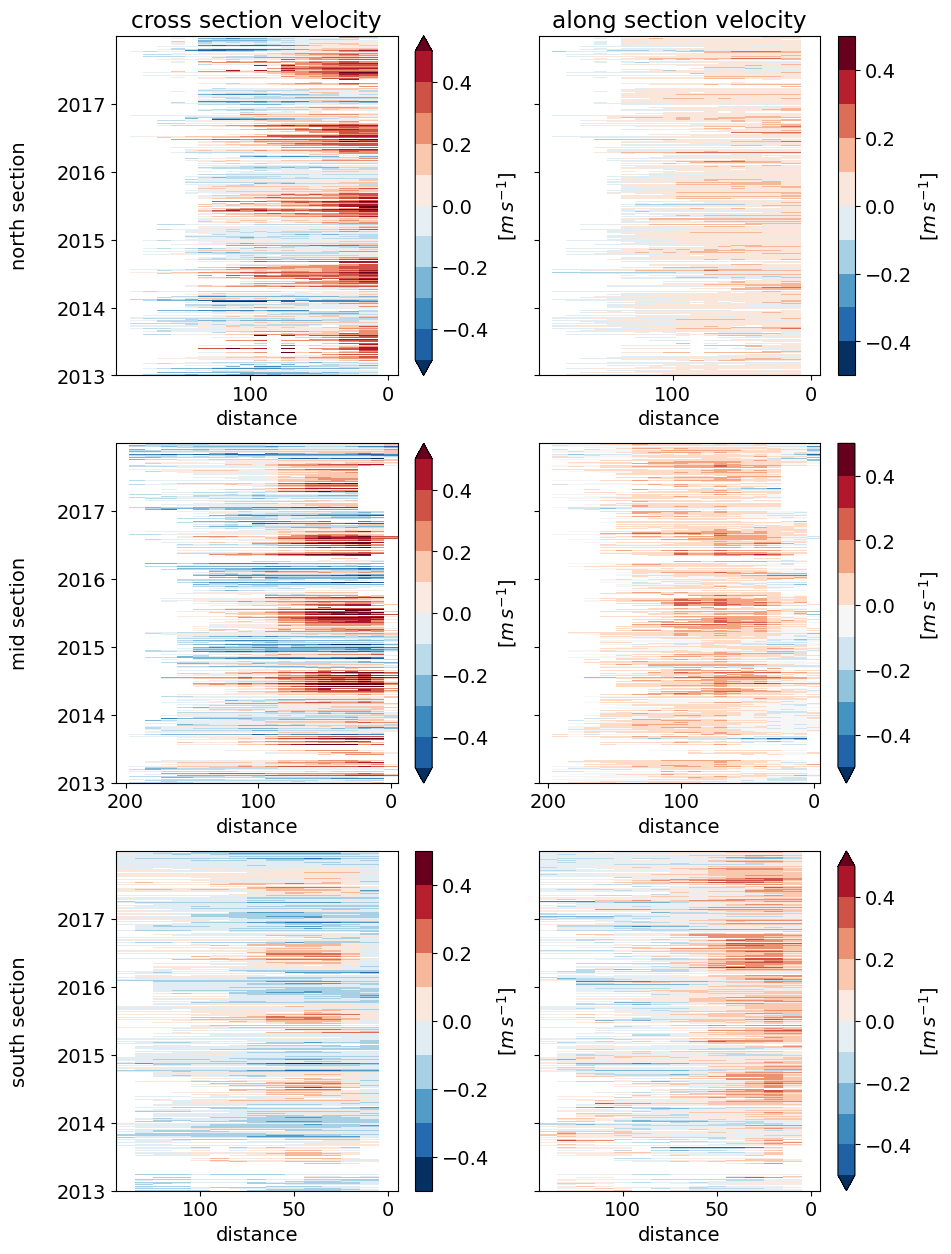

In [223]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharey=True,figsize=(10,15))

north_section.cross_vel.plot(ax=ax1,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
north_section.along_vel.plot(ax=ax2,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

mid_section.cross_vel.plot(ax=ax3,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
mid_section.along_vel.plot(ax=ax4,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

south_section.cross_vel.plot(ax=ax5,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
south_section.along_vel.plot(ax=ax6,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

ax1.set_ylabel('north section\n'),ax2.set_ylabel(''),ax3.set_ylabel('mid section\n'),ax4.set_ylabel(''),ax5.set_ylabel('south section\n'),ax6.set_ylabel('')
ax1.set_title('cross section velocity'),ax2.set_title('along section velocity');


(15706.0, 17532.0)

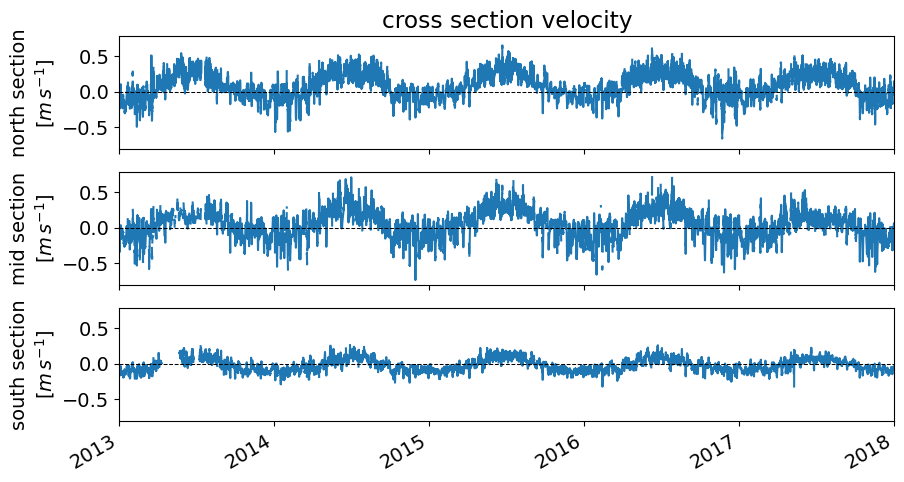

In [221]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,5))
north_section.mean(dim='s').cross_vel.plot(ax=ax1,label='north')
mid_section.mean(dim='s').cross_vel.plot(ax=ax2,label='mid')
south_section.mean(dim='s').cross_vel.plot(ax=ax3,label='south')
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel('')
ax1.set_ylabel('north section\n' + '$[m\,s^{-1}]$'),ax2.set_ylabel('mid section\n' + '$[m\,s^{-1}]$'),ax3.set_ylabel('south section\n' + '$[m\,s^{-1}]$')
ax1.set_title('cross section velocity')

xmin,xmax = datetime(2013,1,1),datetime(2018,1,1)
ax1.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax2.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax3.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax1.set_xlim([xmin,xmax])

In [34]:
velocity_masked = velocity.where(velocity.coverage>0.5)

In [68]:
mean = velocity.mean(dim='time')
std = velocity.std(dim='time')

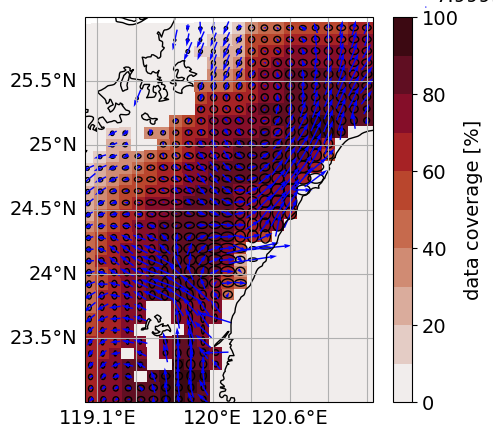

In [73]:
fig, ax = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.isel(x=slice(4,27),y=slice(20,55)).coverage*100).plot(x='lon',y='lat',cmap=cmo.amp,levels=np.arange(0,110,10),cbar_kwargs={'ticks':np.arange(0,120,20),'label':'data coverage [%]'})

for x in np.arange(4,27):
    for y in np.arange(20,55):
        if ~np.isnan(std.isel(x=x,y=y).u_filtered):
            ell = mpl.patches.Ellipse(xy=[std.isel(x=x,y=y).lon,std.isel(x=x,y=y).lat], 
                                      width=std.isel(x=x,y=y).u_filtered/2, height=std.isel(x=x,y=y).v_filtered/2, angle = 0,fc='none',ec='k',transform=ccrs.PlateCarree())

            ax.add_patch(ell)
        else:
            continue
            
# xr.plot.scatter(ax=ax,ds=velocity.isel(x=26,y=20),x='lon',y='lat',transform=ccrs.PlateCarree())
mean.isel(x=slice(4,27),y=slice(20,55)).plot.quiver(ax=ax,x='lon',y='lat',u='u_filtered',v='v_filtered',linewidth=0.5,width=0.005,scale=2,color='b')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_aspect('equal')
ax.autoscale()
ax.set_extent([119,121.25,23,26])
gl.right_labels=False
gl.top_labels=False